In [2]:
# Imports
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
import shapely
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import os
import sys
import pysal.lib.weights as sw # create spatial weights matrix
from pysal.explore.esda import Moran, Moran_Local #global & local Moran's I
from pysal.model import spreg #spatial regression module
from pysal.viz.splot.esda import lisa_cluster, plot_local_autocorrelation
import pysal as ps
# Suppress warnings and adjust settings
import warnings
warnings.filterwarnings('ignore') # Suppress Jupyter Notebook warnings
from IPython.core.display import display, HTML # Set HTML notebooks to max width
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 250)
"Load Complete"

C:\Users\Impul\.conda\envs\geo-ds\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Impul\.conda\envs\geo-ds\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


'Load Complete'

In [3]:
md_blocks = gpd.read_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\MD_blck_grp_2019.shp')
md_blocks = md_blocks.to_crs(epsg=4326)
md_blocks = md_blocks.drop(['NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng',
                           'Shape_Area'], axis=1)
appeals = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\appeals_sf.geojson")
appeals = appeals.drop(['site.address', 'x', 'address_r1', 'r2_address', 'right_match', 'match_address', 'match_type',
                       'state_fips', 'county_fips', 'multi', 'exact', 'address_type'], axis = 1)

# Geocoded Batch 1 cleaning
geocoded1 = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded1.shp")
geocoded1 = geocoded1.rename(columns={'site.addre' : 'site.address', 'account.nu' : 'account.number', 'address_co' : 'address_correct',
                                     'appealed.v' : 'appealed.value', 'final.valu' : 'final.value', 'value.chan' : 'value.change',})
geocoded1 = geocoded1.drop(['field_1', 'x', 'site.address', 'address_r1', 'r2_address', 'right_matc', 'match_addr', 'lat', 'long',
                           'match_type', 'state_fips', 'county_fip', 'census_tra', 'census_blo', 'multi', 'exact', 'address_ty'], axis=1)
# Geocoded Batch 2 cleaning
geocoded2 = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\processed\geocoded2.shp")
geocoded2 = geocoded2.rename(columns={'site.addre' : 'site.address', 'account.nu' : 'account.number', 'address_co' : 'address_correct',
                                     'appealed.v' : 'appealed.value', 'final.valu' : 'final.value', 'value.chan' : 'value.change',})
geocoded2 = geocoded2.drop(['field_1', 'x', 'site.address', 'address_r1', 'r2_address', 'right_matc', 'match_addr', 'lat', 'long',
                           'match_type', 'state_fips', 'county_fip', 'census_tra', 'census_blo', 'multi', 'exact', 'address_ty'], axis=1)

# Combine geocoded data into one final dataframe
final_appeals = gpd.GeoDataFrame(pd.concat([appeals, geocoded1, geocoded2], ignore_index=True))

md_hex = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\md_hex_bins.shp")
"complete"

'complete'

In [3]:
final_appeals.dtypes

county               object
account.number       object
zip.code             object
tax.year             object
appealed.value       object
final.value          object
value.change         object
address_correct      object
census_tract         object
census_block         object
num_appeals         float64
pct_change          float64
type_change          object
geometry           geometry
dtype: object

In [54]:
# Final dataframe cleaning
final_appeals['num_appeals'] = final_appeals['num_appeals'].fillna(1.0)
final_appeals['value.change'] = pd.to_numeric(final_appeals['value.change'])
final_appeals['appealed.value'] = pd.to_numeric(final_appeals['appealed.value'])
final_appeals['final.value'] = final_appeals['final.value'].fillna(0).replace("NULL", 0)
final_appeals['final.value'] = pd.to_numeric(final_appeals['final.value'])
final_appeals['value.change'] = final_appeals['appealed.value'] - final_appeals['final.value']
final_appeals['type_change'] = final_appeals['type_change'].fillna("None")
final_appeals['pct_change'] = final_appeals['pct_change'].fillna(0.0)
final_appeals

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,address_correct,census_tract,census_block,num_appeals,pct_change,type_change,geometry
0,Allegany,0116009105,21502,2016,171300,163700,7600,12501 GOLDENS AVE CUMBERLAND MD,000200,3010,1.0,4.4,Decrease,POINT (-78.73335 39.60901)
1,Allegany,0116009784,21502,2016,115700,55500,60200,12301 PINEY FLATS RD CUMBERLAND MD,000200,1025,1.0,52.0,Decrease,POINT (-78.69448 39.62848)
2,Allegany,0121002194,21502,2016,98000,98000,0,14406 BALTIMORE PIKE CUMBERLAND MD,000200,2019,1.0,-0.0,None,POINT (-78.70073 39.67919)
3,Allegany,0121002208,21502,2016,54300,36600,17700,14400 BALTIMORE PIKE CUMBERLAND MD,000200,2019,2.0,32.6,Decrease,POINT (-78.70181 39.67930)
4,Allegany,0121002224,21502,2016,77800,53200,24600,14400 BALTIMORE PIKE CUMBERLAND MD,000200,2019,2.0,31.6,Decrease,POINT (-78.70181 39.67930)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58104,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.49114 38.20224)
58105,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.49114 38.20224)
58106,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.53639 38.18284)
58107,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.53639 38.18284)


In [5]:
md_hex = gpd.read_file(r"F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\md_hex_bins.shp")
merge_df = gpd.sjoin(final_appeals, md_hex, how="left", op="within")
merge_df = merge_df.drop(['index_right'], axis=1)
merge_df

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,address_correct,census_tract,census_block,num_appeals,pct_change,type_change,geometry,hex_id
0,Allegany,0116009105,21502,2016,171300,163700,7600,12501 GOLDENS AVE CUMBERLAND MD,000200,3010,1.0,4.4,Decrease,POINT (-78.73335 39.60901),NaN
1,Allegany,0116009784,21502,2016,115700,55500,60200,12301 PINEY FLATS RD CUMBERLAND MD,000200,1025,1.0,52.0,Decrease,POINT (-78.69448 39.62848),872a85073ffffff
2,Allegany,0121002194,21502,2016,98000,98000,0,14406 BALTIMORE PIKE CUMBERLAND MD,000200,2019,1.0,-0.0,None,POINT (-78.70073 39.67919),872a85076ffffff
3,Allegany,0121002208,21502,2016,54300,36600,17700,14400 BALTIMORE PIKE CUMBERLAND MD,000200,2019,2.0,32.6,Decrease,POINT (-78.70181 39.67930),872a85076ffffff
4,Allegany,0121002224,21502,2016,77800,53200,24600,14400 BALTIMORE PIKE CUMBERLAND MD,000200,2019,2.0,31.6,Decrease,POINT (-78.70181 39.67930),872a85076ffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58104,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.49114 38.20224),872aa98caffffff
58105,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.49114 38.20224),872aa98caffffff
58106,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.53639 38.18284),872aa9166ffffff
58107,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL MD,NaN,NaN,1.0,0.0,None,POINT (-75.53639 38.18284),872aa9166ffffff


In [6]:
# Sum of number of appeals that occurred in each hex bin spatial unit
appeals_sum = merge_df.groupby('hex_id').sum()
# appeals_sum = appeals_sum.drop(['appealed.value', 'final.value', 'pct_change', 'value_change'], axis=1)
appeals_sum = appeals_sum.reset_index()
appeals_sum

,hex_id,appealed.value,final.value,value.change,num_appeals,pct_change
0,872a1a494ffffff,2827000,2827000,0,7.0,0.0
1,872a1a496ffffff,6748700,6530800,217900,11.0,27.8
2,872a1a4b2ffffff,667400,637600,29800,2.0,6.7
3,872a1a4b4ffffff,18256100,17570100,686000,41.0,197.6
4,872a1a4b6ffffff,7442400,6586800,855600,1304.0,97.8
...,...,...,...,...,...,...
3035,872aaeb5dffffff,4363600,4219100,144500,10.0,32.8
3036,872aaeb5effffff,1371900,1371900,0,4.0,0.0
3037,872aaeb69ffffff,702200,700600,1600,2.0,0.4
3038,872aaeb6bffffff,341200,341200,0,2.0,0.0


In [7]:
# Average of the percentage change of all appeals that happened in each hex bin spatial unit
pct_change_mean = merge_df.groupby('hex_id').mean()
# pct_change_mean = pct_change_mean.drop(['appealed.value', 'final.value', 'num_appeals', 'value_change'], axis=1)
pct_change_mean = pct_change_mean.reset_index()
pct_change_mean

,hex_id,appealed.value,final.value,value.change,num_appeals,pct_change
0,872a1a494ffffff,565400.000000,565400.000000,0.000000,1.400000,0.000000
1,872a1a496ffffff,749855.555556,725644.444444,24211.111111,1.222222,3.088889
2,872a1a4b2ffffff,333700.000000,318800.000000,14900.000000,1.000000,3.350000
3,872a1a4b4ffffff,521602.857143,502002.857143,19600.000000,1.171429,5.645714
4,872a1a4b6ffffff,169145.454545,149700.000000,19445.454545,29.636364,2.222727
...,...,...,...,...,...,...
3035,872aaeb5dffffff,436360.000000,421910.000000,14450.000000,1.000000,3.280000
3036,872aaeb5effffff,342975.000000,342975.000000,0.000000,1.000000,0.000000
3037,872aaeb69ffffff,351100.000000,350300.000000,800.000000,1.000000,0.200000
3038,872aaeb6bffffff,170600.000000,170600.000000,0.000000,1.000000,0.000000


In [8]:
# Merging the aggregate spatial data to the original hex bins GDF
spatial_merged = md_hex.merge(appeals_sum, how='outer')
spatial_merged = spatial_merged.merge(pct_change_mean, how='outer')
# spatial_merged = spatial_merged.fillna(0)
spatial_merged = spatial_merged.dropna()
spatial_merged

,hex_id,geometry,appealed.value,final.value,value.change,num_appeals,pct_change
0,872aac75dffffff,"POLYGON ((-76.12378 39.59100, -76.10868 39.585...",235500.0,222100.0,13400.0,1.0,5.7
1,872aae06affffff,"POLYGON ((-77.18907 39.68336, -77.17381 39.678...",644000.0,545200.0,98800.0,3.0,44.1
2,872aa871effffff,"POLYGON ((-76.90922 38.80641, -76.89427 38.801...",6291700.0,6073200.0,218500.0,27.0,68.4
3,872aa8d03ffffff,"POLYGON ((-76.60951 39.45799, -76.59439 39.452...",26725600.0,26168200.0,557400.0,84.0,130.2
4,872aae2f1ffffff,"POLYGON ((-77.29942 39.34820, -77.28426 39.342...",319600.0,319600.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
5014,872aac0caffffff,"POLYGON ((-76.01594 39.70563, -76.00081 39.700...",419100.0,401100.0,18000.0,1.0,4.3
5015,872aac230ffffff,"POLYGON ((-75.79980 39.56895, -75.78474 39.563...",3323200.0,3033600.0,289600.0,10.0,56.8
5016,872aac3b4ffffff,"POLYGON ((-75.89888 39.71085, -75.88376 39.705...",3710800.0,3659200.0,51600.0,13.0,11.1
5017,872aac398ffffff,"POLYGON ((-75.94862 39.59894, -75.93353 39.593...",3212600.0,2977500.0,235100.0,12.0,133.1


In [9]:
# spatial_merged['num_appeals'].idxmax()
# spatial_merged['num_appeals'].loc[986] = 747310 / 10
# spatial_merged['num_appeals'].max()
# spatial_merged['num_appeals'].sum()

(array([722., 411., 234., 194., 165., 109., 108.,  78.,  50.,  59.,  57.,
         41.,  46.,  31.,  37.,  28.,  31.,  21.,  21.,  20.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

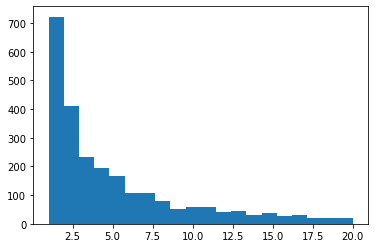

In [10]:
plt.hist(spatial_merged['num_appeals'], bins=20,  range=(1, 20))

Text(0.5, 1.0, 'Number of appeals per hex bin')

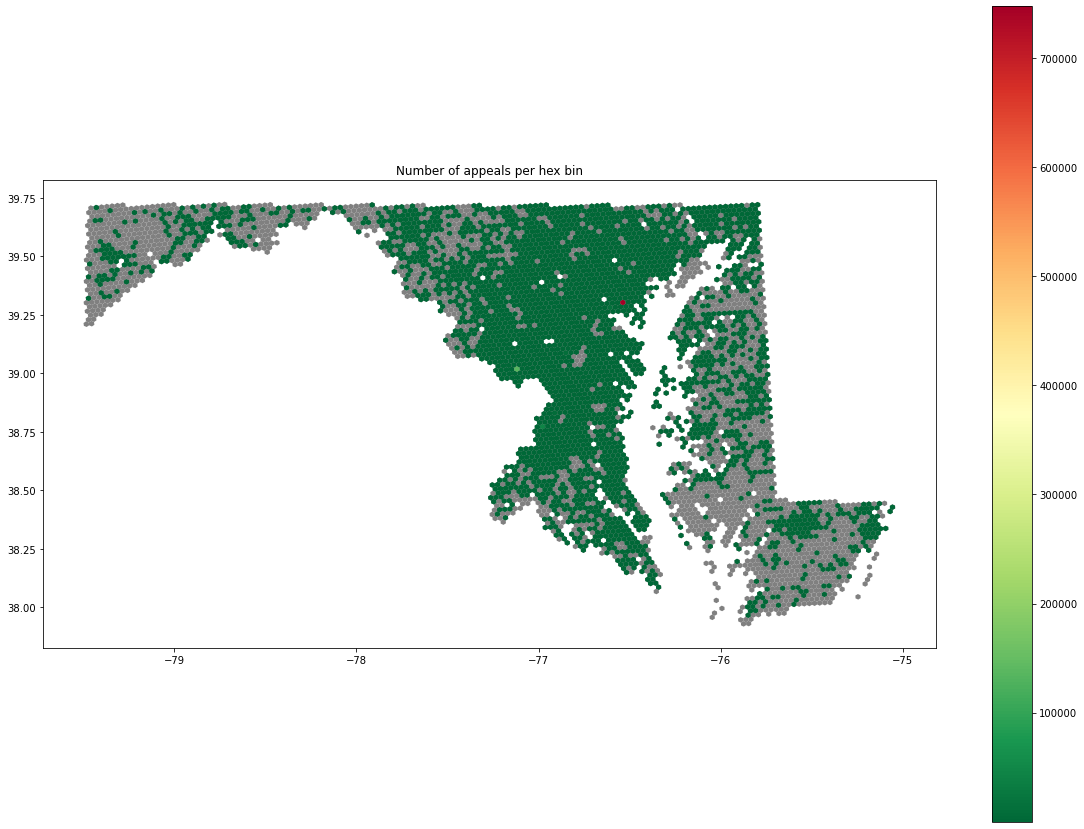

In [11]:
fig, ax = plt.subplots(figsize=(20,15))
md_hex.plot(ax=ax, facecolor='gray')
spatial_merged.plot(spatial_merged['num_appeals'], ax=ax, cmap='RdYlGn_r', legend=True)
plt.title('Number of appeals per hex bin')

Text(0.5, 1.0, '% change by hex bin')

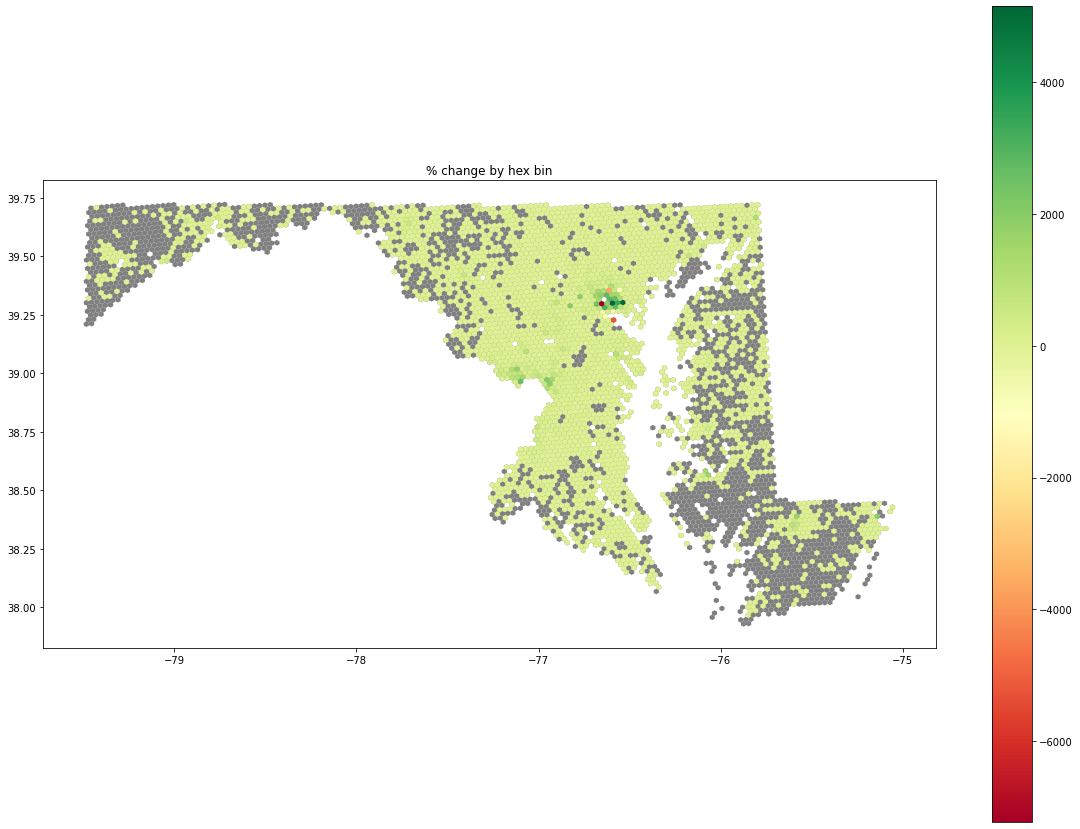

In [12]:
fig, ax = plt.subplots(figsize=(20,15))
md_hex.plot(ax=ax, facecolor='gray')
spatial_merged.plot(spatial_merged['pct_change'], ax=ax, cmap='RdYlGn', legend=True)
plt.title('% change by hex bin')

## Moran's I

In [13]:
# Create spatial weights matrix
w = sw.Queen.from_dataframe(spatial_merged)

In [14]:
# Calculate Global Moran's I - number of appeals
morans_appeals = Moran(spatial_merged['num_appeals'], w)
print(morans_appeals.I, morans_appeals.p_sim)
# Result is almost 0 (very close to perfectly random)

('WARNING: ', 136, ' is an island (no neighbors)')
('WARNING: ', 238, ' is an island (no neighbors)')
('WARNING: ', 257, ' is an island (no neighbors)')
('WARNING: ', 315, ' is an island (no neighbors)')
('WARNING: ', 732, ' is an island (no neighbors)')
('WARNING: ', 741, ' is an island (no neighbors)')
('WARNING: ', 1123, ' is an island (no neighbors)')
('WARNING: ', 1359, ' is an island (no neighbors)')
('WARNING: ', 1908, ' is an island (no neighbors)')
('WARNING: ', 2134, ' is an island (no neighbors)')
('WARNING: ', 2146, ' is an island (no neighbors)')
('WARNING: ', 2151, ' is an island (no neighbors)')
('WARNING: ', 2157, ' is an island (no neighbors)')
('WARNING: ', 2182, ' is an island (no neighbors)')
('WARNING: ', 2188, ' is an island (no neighbors)')
('WARNING: ', 2218, ' is an island (no neighbors)')
('WARNING: ', 2230, ' is an island (no neighbors)')
('WARNING: ', 2231, ' is an island (no neighbors)')
('WARNING: ', 2237, ' is an island (no neighbors)')
('WARNING: ', 2238

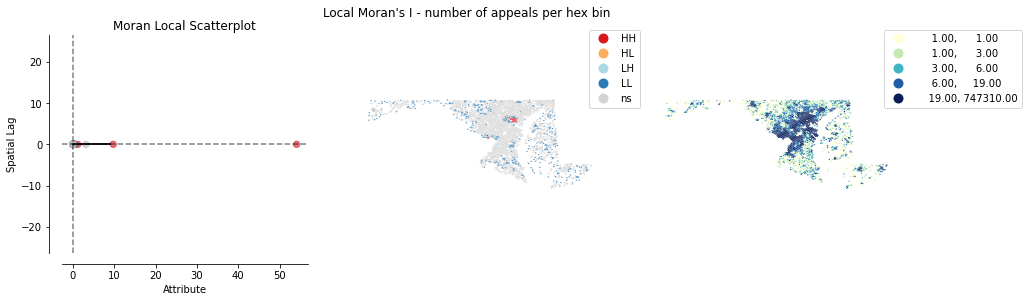

In [15]:
# Calculate Local Moran's I - number of appeals
local_morans_appeals = Moran_Local(spatial_merged['num_appeals'], w)
# Plot Hot/Cold spots
fig = plot_local_autocorrelation(local_morans_appeals, spatial_merged, 'num_appeals', p=0.05)
plt.suptitle("Local Moran's I - number of appeals per hex bin")
plt.show()

In [16]:
# Calculate Global Moran's I % Changed
morans_pct_change = Moran(spatial_merged['pct_change'], w)
print(morans_pct_change.I, morans_pct_change.p_sim)
# Result is almost 0 (very close to perfectly random)

0.24982797971855802 0.001


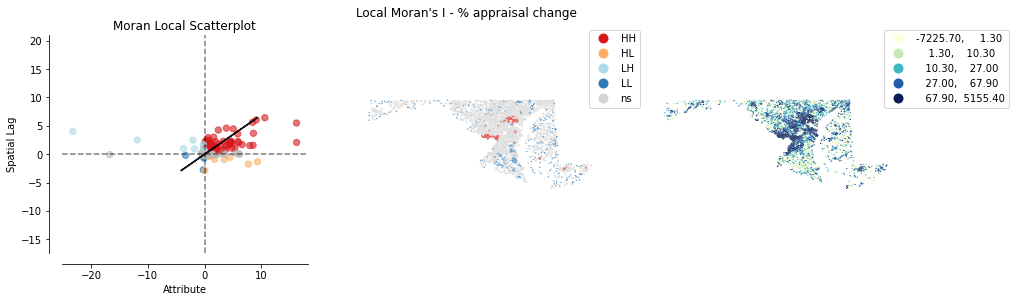

In [17]:
# Calculate Local Moran's I % Changed
local_morans_pct_change = Moran_Local(spatial_merged['pct_change'], w)
# Plot Hot/Cold spots
fig = plot_local_autocorrelation(local_morans_pct_change, spatial_merged, 'pct_change', p=0.05)
plt.suptitle("Local Moran's I - % appraisal change")
plt.show()

## Moran's Census

In [75]:
# MD Block data
md_blocks = gpd.read_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\MD_blck_grp_2019.shp')
md_blocks = md_blocks.to_crs(epsg=4326)
md_blocks = md_blocks.drop(['NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng',
                           'Shape_Area'], axis=1)

# Census Data
census_df = pd.read_csv(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\source\nhgis-blck_grp-edit.csv')
census_df['GEOID'] = census_df['GEOID'].str[7:]
census_df = census_df.drop(['YEAR', 'GISJOIN', 'STUSAB', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA', 'COUSUBA',
                           'PLACEA', 'census_tract', 'BLKGRPA', 'BTTRA', 'BTBGA', 'NAME_E'], axis=1)

In [76]:
appeals_tracts = gpd.sjoin(final_appeals, md_blocks, how="left", op="within").drop(['index_right', 'census_tract', 'census_block', 
                                                                                    'GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE'], axis=1)
appeals_tracts

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,address_correct,num_appeals,pct_change,type_change,geometry,GEOID
0,Allegany,0116009105,21502,2016,171300,163700,7600,12501 GOLDENS AVE CUMBERLAND MD,1.0,4.4,Decrease,POINT (-78.73335 39.60901),240010002003
1,Allegany,0116009784,21502,2016,115700,55500,60200,12301 PINEY FLATS RD CUMBERLAND MD,1.0,52.0,Decrease,POINT (-78.69448 39.62848),240010002001
2,Allegany,0121002194,21502,2016,98000,98000,0,14406 BALTIMORE PIKE CUMBERLAND MD,1.0,-0.0,None,POINT (-78.70073 39.67919),240010002002
3,Allegany,0121002208,21502,2016,54300,36600,17700,14400 BALTIMORE PIKE CUMBERLAND MD,2.0,32.6,Decrease,POINT (-78.70181 39.67930),240010002002
4,Allegany,0121002224,21502,2016,77800,53200,24600,14400 BALTIMORE PIKE CUMBERLAND MD,2.0,31.6,Decrease,POINT (-78.70181 39.67930),240010002002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58104,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL MD,1.0,0.0,None,POINT (-75.49114 38.20224),240479514002
58105,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL MD,1.0,0.0,None,POINT (-75.49114 38.20224),240479514002
58106,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL MD,1.0,0.0,None,POINT (-75.53639 38.18284),240479514002
58107,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL MD,1.0,0.0,None,POINT (-75.53639 38.18284),240479514002


In [77]:
final_df = appeals_tracts.merge(census_df, how='left', on='GEOID')
final_df

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,address_correct,num_appeals,pct_change,type_change,geometry,GEOID,ALUBE001,ALUCE001,ALUCE002,ALUCE003,ALUCE004,ALUCE005,ALUCE006,ALUCE007,ALUCE008,ALUCE009,ALUCE010,ALUKE001,ALUKE002,ALUKE003,ALUKE004,ALUKE005,ALUKE006,ALUKE007,ALUKE008,ALUKE009,ALUKE010,ALUKE011,ALUKE012,ALUKE013,ALUKE014,ALUKE015,ALUKE016,ALUKE017,ALUKE018,ALUKE019,ALUKE020,ALUKE021,ALU9E001,ALU9E002,ALU9E003,ALU9E004,ALU9E005,...,ALW0M012,ALW0M013,ALW0M014,ALW0M015,ALW0M016,ALW0M017,ALW1M001,ALX5M001,ALZJM001,ALZWM001,ALZWM002,ALZWM003,ALZWM004,ALZWM005,ALZWM006,ALZWM007,ALZWM008,ALZWM009,ALZWM010,ALZ0M001,ALZ0M002,ALZ0M003,AL1FM001,AL1FM002,AL1FM003,AL1FM004,AL1FM005,AL1FM006,AL1FM007,AL1FM008,AL1FM009,AL1FM010,AL1FM011,AL1FM012,AL1FM013,AL1FM014,AL1FM015,AL1FM016,AL1FM017,AL1FM018,AL1FM019,AL1FM020,AL1FM021,AL1FM022,AL1FM023,AL1FM024,AL1FM025,AL1FM026,AL1FM027,AL1HM001
0,Allegany,0116009105,21502,2016,171300,163700,7600,12501 GOLDENS AVE CUMBERLAND MD,1.0,4.4,Decrease,POINT (-78.73335 39.60901),240010002003,2197.0,2197.0,1154.0,852.0,0.0,30.0,0.0,86.0,75.0,30.0,45.0,2197.0,2045.0,1102.0,852.0,0.0,30.0,0.0,0.0,61.0,30.0,31.0,152.0,52.0,0.0,0.0,0.0,0.0,86.0,14.0,0.0,14.0,346.0,218.0,199.0,19.0,9.0,...,46.0,32.0,26.0,12.0,18.0,12.0,13457.0,3107.0,61.0,63.0,63.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.58,0.72,0.83,60.0,12.0,14.0,12.0,12.0,10.0,12.0,17.0,10.0,12.0,17.0,12.0,33.0,20.0,14.0,28.0,35.0,12.0,30.0,24.0,20.0,12.0,23.0,12.0,12.0,12.0,12.0,23758.0
1,Allegany,0116009784,21502,2016,115700,55500,60200,12301 PINEY FLATS RD CUMBERLAND MD,1.0,52.0,Decrease,POINT (-78.69448 39.62848),240010002001,665.0,665.0,623.0,4.0,0.0,15.0,0.0,0.0,23.0,0.0,23.0,665.0,665.0,623.0,4.0,0.0,15.0,0.0,0.0,23.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,301.0,152.0,130.0,22.0,11.0,...,34.0,47.0,27.0,18.0,11.0,16.0,19213.0,29570.0,82.0,67.0,67.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.40,0.45,0.91,60.0,12.0,12.0,12.0,12.0,12.0,12.0,38.0,13.0,16.0,12.0,12.0,29.0,12.0,25.0,19.0,33.0,12.0,21.0,17.0,38.0,12.0,12.0,12.0,12.0,12.0,12.0,43222.0
2,Allegany,0121002194,21502,2016,98000,98000,0,14406 BALTIMORE PIKE CUMBERLAND MD,1.0,-0.0,None,POINT (-78.70073 39.67919),240010002002,1115.0,1115.0,1060.0,0.0,0.0,46.0,9.0,0.0,0.0,0.0,0.0,1115.0,1115.0,1060.0,0.0,0.0,46.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,482.0,296.0,246.0,50.0,26.0,...,32.0,49.0,41.0,13.0,24.0,12.0,32498.0,3818.0,82.0,73.0,73.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.27,0.35,0.55,68.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,17.0,35.0,40.0,30.0,29.0,34.0,19.0,36.0,14.0,29.0,21.0,23.0,12.0,12.0,12.0,12.0,12.0,12.0,18326.0
3,Allegany,0121002208,21502,2016,54300,36600,17700,14400 BALTIMORE PIKE CUMBERLAND MD,2.0,32.6,Decrease,POINT (-78.70181 39.67930),240010002002,1115.0,1115.0,1060.0,0.0,0.0,46.0,9.0,0.0,0.0,0.0,0.0,1115.0,1115.0,1060.0,0.0,0.0,46.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,482.0,296.0,246.0,50.0,26.0,...,32.0,49.0,41.0,13.0,24.0,12.0,32498.0,3818.0,82.0,73.0,73.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.27,0.35,0.55,68.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,17.0,35.0,40.0,30.0,29.0,34.0,19.0,36.0,14.0,29.0,21.0,23.0,12.0,12.0,12.0,12.0,12.0,12.0,18326.0
4,Allegany,0121002224,21502,2016,77800,53200,24600,14400 BALTIMORE PIKE CUMBERLAND MD,2.0,31.6,Decrease,POINT (-78.70181 39.67930),240010002002,1115.0,1115.0,1060.0,0.0,0.0,46.0,9.0,0.0,0.0,0.0,0.0,1115.0,1115.0,1060.0,0.0,0.0,46.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,482.0,296.0,246.0,50.0,26.0,...,32.0,49.0,41.0,13.0,24.0,12.0,32498.0,3818.0,82.0,73.0,73.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.27,0.35,0.55,68.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,17.0,35.0,40.0,30.0,29.0,34.0,19.0,36.0,14.0,29.0,21.0,23.0,12.0,12.0,12.0,12.0,12.0,12.0,18326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [83]:
# final_df.to_csv(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\appeals_tracts_census_merge-FINAL.csv')
# final_df.to_file('dataframe.shp')
# final_df.to_file(r'F:\Assignments\INST490\tax_project\maryland_tax_valuations\data\appeals_tracts_census_merge-FINAL.geojson', driver='GeoJSON')

In [5]:
merge_tr = gpd.sjoin(final_appeals, md_blocks, how="left", op="within")
merge_tr

,county,account.number,zip.code,tax.year,appealed.value,final.value,value.change,address_correct,census_tract,census_block,num_appeals,pct_change,type_change,geometry,index_right,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID
0,Allegany,0116009105,21502,2016,171300,163700,-7600,12501 GOLDENS AVE CUMBERLAND MD,000200,3010,1.0,4.4,Decrease,POINT (-78.73335 39.60901),5.0,G24000100002003,24,001,000200,3,240010002003
1,Allegany,0116009784,21502,2016,115700,55500,-60200,12301 PINEY FLATS RD CUMBERLAND MD,000200,1025,1.0,52.0,Decrease,POINT (-78.69448 39.62848),3.0,G24000100002001,24,001,000200,1,240010002001
2,Allegany,0121002194,21502,2016,98000,98000,0,14406 BALTIMORE PIKE CUMBERLAND MD,000200,2019,1.0,-0.0,None,POINT (-78.70073 39.67919),4.0,G24000100002002,24,001,000200,2,240010002002
3,Allegany,0121002208,21502,2016,54300,36600,-17700,14400 BALTIMORE PIKE CUMBERLAND MD,000200,2019,2.0,32.6,Decrease,POINT (-78.70181 39.67930),4.0,G24000100002002,24,001,000200,2,240010002002
4,Allegany,0121002224,21502,2016,77800,53200,-24600,14400 BALTIMORE PIKE CUMBERLAND MD,000200,2019,2.0,31.6,Decrease,POINT (-78.70181 39.67930),4.0,G24000100002002,24,001,000200,2,240010002002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58104,Worcester,2407003986,21863,2020,61300,61300,0,1926 OLD FURNACE RD SNOW HILL MD,NaN,NaN,NaN,NaN,NaN,POINT (-75.49114 38.20224),3249.0,G24004709514002,24,047,951400,2,240479514002
58105,Worcester,2407004001,21863,2020,24800,24800,0,0 OLD FURNACE RD SNOW HILL MD,NaN,NaN,NaN,NaN,NaN,POINT (-75.49114 38.20224),3249.0,G24004709514002,24,047,951400,2,240479514002
58106,Worcester,2407004907,21863,2020,77900,77900,0,5539 WHITESBURG RD WEST OF SNOW HILL MD,NaN,NaN,NaN,NaN,NaN,POINT (-75.53639 38.18284),3249.0,G24004709514002,24,047,951400,2,240479514002
58107,Worcester,2407006349,21863,2020,283700,283700,0,0 WHITESBURG RD WEST OF SNOW HILL MD,NaN,NaN,NaN,NaN,NaN,POINT (-75.53639 38.18284),3249.0,G24004709514002,24,047,951400,2,240479514002


In [36]:
# Retrieving median percent change and number of appeals for each tract/GEOID
pct_medians = merge_tr.groupby('GEOID').median()
pct_medians = pct_medians.reset_index()
pct_medians = pct_medians.drop(columns=['index_right'], axis=1)

tr_merged = md_blocks.merge(pct_medians, how='outer')
tr_merged =tr_merged.fillna(0)

tr_merged

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,geometry,num_appeals,pct_change
0,G24000100001001,24,001,000100,1,240010001001,"POLYGON ((-78.34283 39.72226, -78.34273 39.722...",1.0,16.7
1,G24000100001002,24,001,000100,2,240010001002,"POLYGON ((-78.49645 39.60403, -78.49704 39.604...",1.0,7.8
2,G24000100001003,24,001,000100,3,240010001003,"POLYGON ((-78.45216 39.53796, -78.45223 39.537...",1.0,19.6
3,G24000100002001,24,001,000200,1,240010002001,"POLYGON ((-78.66649 39.64302, -78.66636 39.642...",1.0,7.5
4,G24000100002002,24,001,000200,2,240010002002,"POLYGON ((-78.66649 39.64302, -78.66680 39.643...",1.0,6.9
...,...,...,...,...,...,...,...,...,...
3910,G24051002804042,24,510,280404,2,245102804042,"POLYGON ((-76.68892 39.28820, -76.68929 39.288...",0.0,0.0
3911,G24051002805001,24,510,280500,1,245102805001,"POLYGON ((-76.59441 39.29837, -76.59436 39.297...",0.0,0.0
3912,G24051002805002,24,510,280500,2,245102805002,"POLYGON ((-76.60299 39.29479, -76.60293 39.293...",1.0,-0.0
3913,G24051002805003,24,510,280500,3,245102805003,"POLYGON ((-76.59983 39.29492, -76.60046 39.294...",1.0,-0.0


Text(0.5, 1.0, 'Median number of appeals by census tract/block')

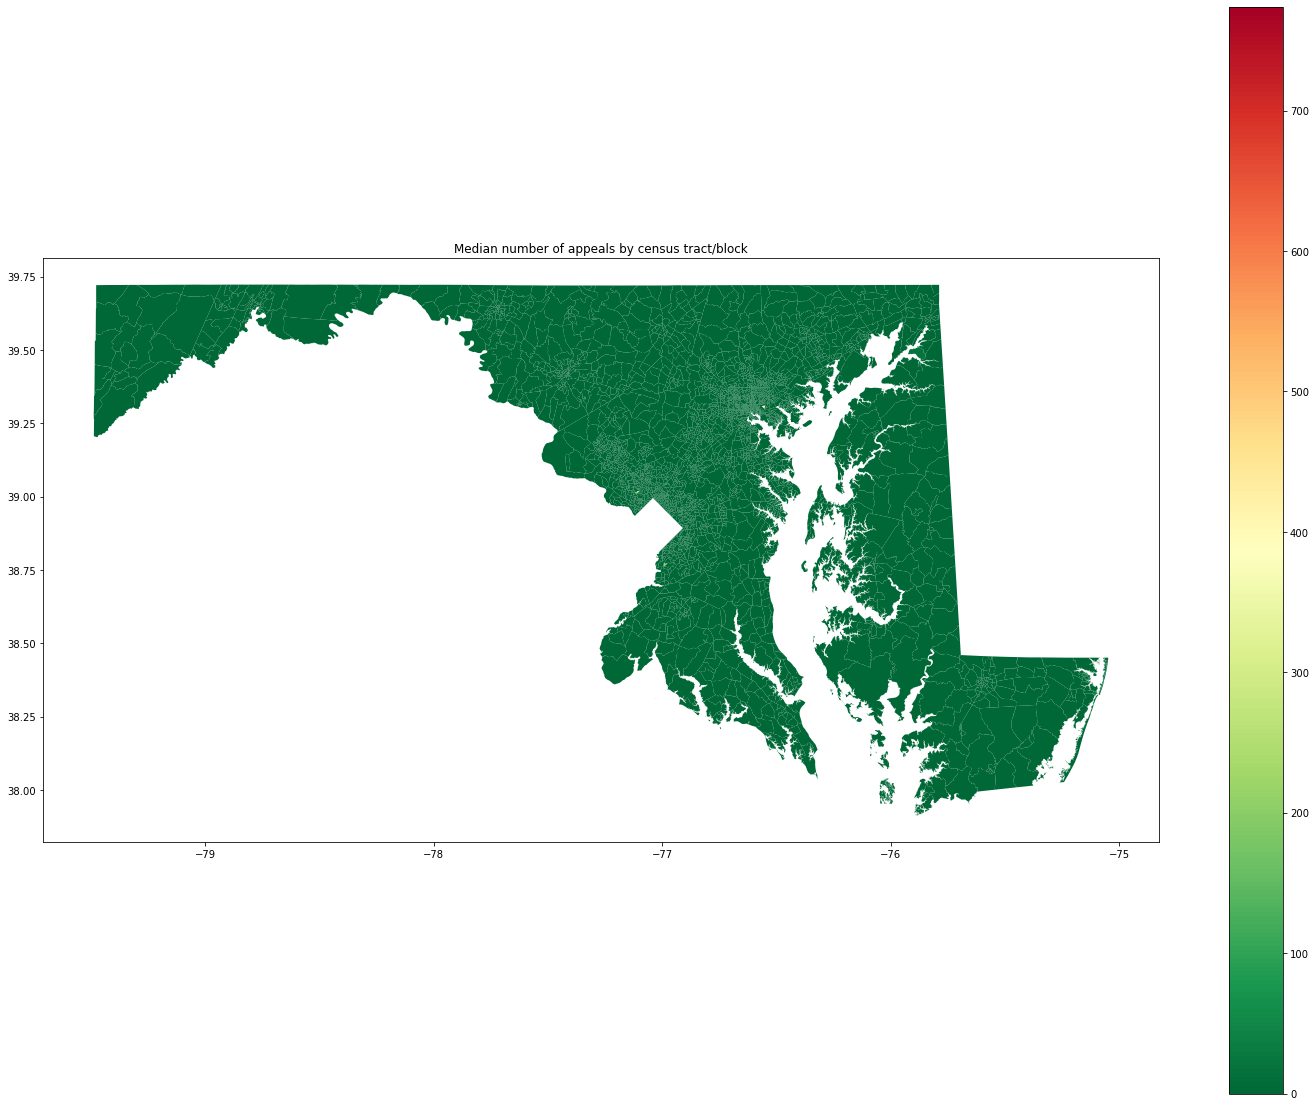

In [47]:
# Median number of appeals by census tract/block
fig, ax = plt.subplots(figsize=(25,20))
tr_merged.plot(tr_merged['num_appeals'], ax=ax, cmap='RdYlGn_r', legend=True)
plt.title('Median number of appeals by census tract/block')

Text(0.5, 1.0, 'Num appeals by census tract/block')

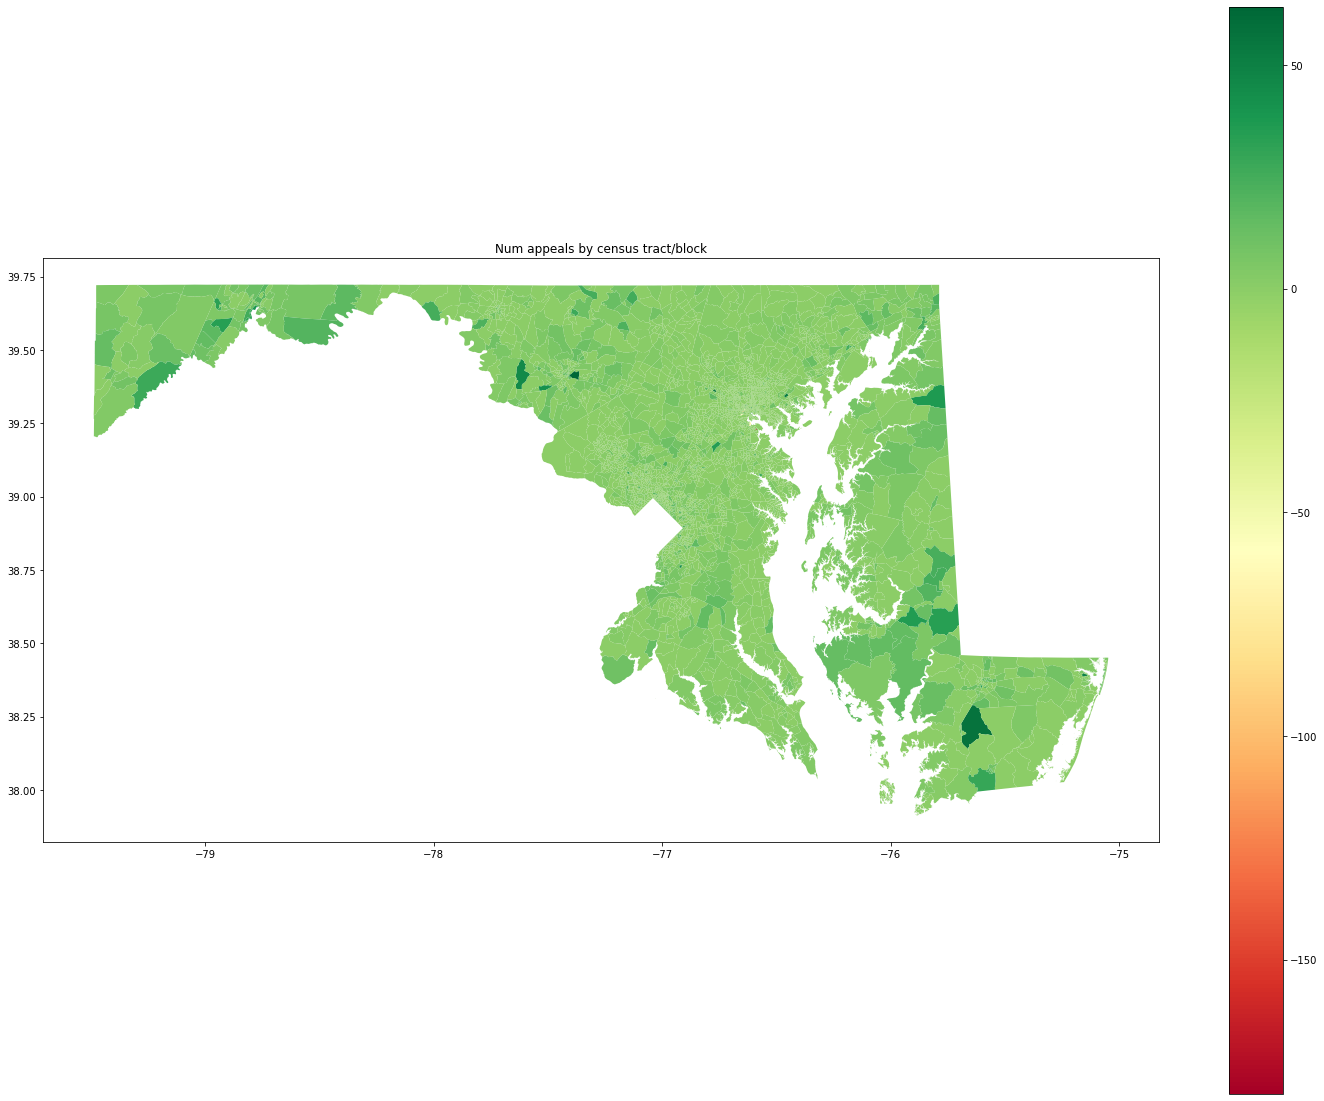

In [48]:
# Median percent change by census tract/block
fig, ax = plt.subplots(figsize=(25,20))
tr_merged.plot(tr_merged['pct_change'], ax=ax, cmap='RdYlGn', legend=True)
plt.title('Num appeals by census tract/block')

In [49]:
W = sw.Queen.from_dataframe(tr_merged)

In [51]:
# Global Moran's I - Statistically insignificant
morans_tr_numapp = Moran(tr_merged['num_appeals'], W)
print(morans_tr_numapp.I, morans_tr_numapp.p_sim)
# Result is almost 0 (very close to perfectly random)
morans_tr_pctch = Moran(tr_merged['pct_change'], W)
print(morans_tr_pctch.I, morans_tr_pctch.p_sim)

0.21278327981488762 0.001
0.10119345623652756 0.001


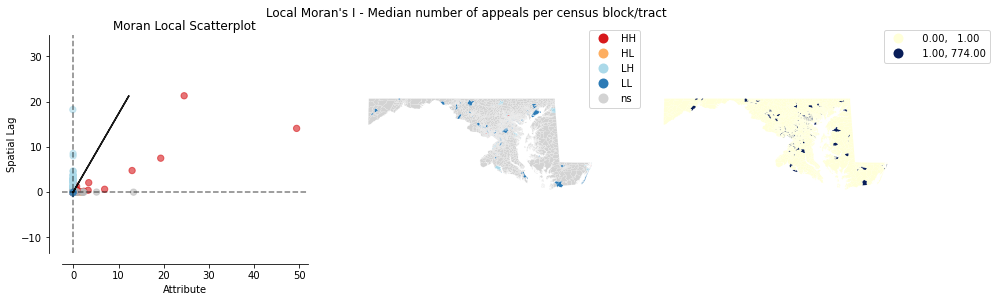

In [52]:
lm_appeals = Moran_Local(tr_merged['num_appeals'], W)
# Plot Hot/Cold spots
fig = plot_local_autocorrelation(lm_appeals, tr_merged, 'num_appeals', p=0.05)
plt.suptitle("Local Moran's I - Median number of appeals per census block/tract")
plt.show()

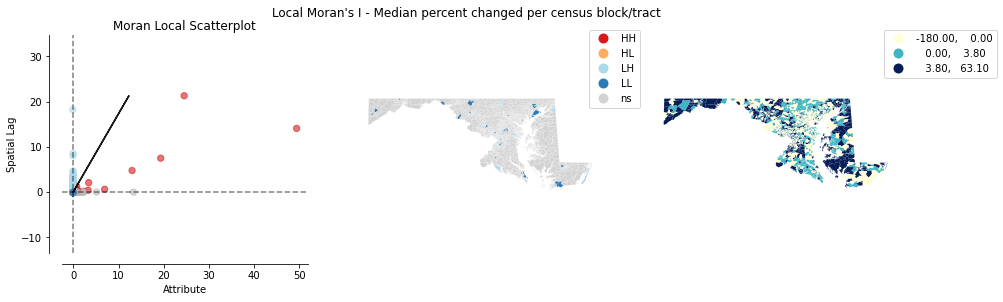

In [53]:
lm_pct_change = Moran_Local(tr_merged['num_appeals'], W)
# Plot Hot/Cold spots
fig = plot_local_autocorrelation(lm_pct_change, tr_merged, 'pct_change', p=0.05)
plt.suptitle("Local Moran's I - Median percent changed per census block/tract")
plt.show()

In [58]:
lm_appeals.p_sim.mean(), lm_pct_change.p_sim.mean()

(0.2278250319284802, 0.22788863346104724)